# Toxic comments
### The code below is used to initialize google colab, if you test the code on your own computer, you need to comment out these codes.

In [1]:
# pour installer les modules necessaires
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

/bin/sh: 1: google-drive-ocamlfuse: not found


In [2]:
# pour installer les modules necessaires et authenticate chaque connexion
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
!pip install skorch
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
W: chmod 0700 of directory /var/lib/apt/lists/partial failed - SetupAPTPartialDirectory (1: Operation not permitted)
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


ModuleNotFoundError: No module named 'google.colab'

# Upload training data
### The code below is used to upload data to Google Colab, if you test the code on your own computer, you need to comment out these codes.

In [4]:
# il faut telechager test.csv, train.csv, pretrain-glove file et sample_submission.csv si vous n'avez pas encore fait
!mkdir -p drive
!google-drive-ocamlfuse drive
from google.colab import files
uploaded = files.upload()

/bin/sh: 1: google-drive-ocamlfuse: not found


ModuleNotFoundError: No module named 'google.colab'

# Import module

In [1]:
import re
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.utils.data
import time
import matplotlib.pyplot as plt
from keras.preprocessing import text, sequence
from sklearn.metrics import roc_auc_score
from torch import nn, optim
from torch.autograd import Variable
#from skorch.net import NeuralNetClassifier

Using TensorFlow backend.


# Display data

In [2]:
#=======================================
# real parameters for train
#=======================================
batch_size = 128 # batch size for train
MAX_NB_WORDS = 100000 # maximal word number considered
max_features = MAX_NB_WORDS
maxlen = 150          # maximal word number in one sentence
embed_size = 100      # word's vector length
TRAIN_FILE = "original data/train.csv"
TEST_FILE = "original data/test.csv"
# emb_file is the pre-train file generated by glove
emb_file = 'original data/pretrain.glove.100d.txt'
n_splits = 10         # k-fold cross validation parameter, error occur if number of data is too small
#----------------------------------------

#=======================================
# small test before running long time train
#=======================================
# batch_size = 25
# MAX_NB_WORDS = 100000 # maximal word number considered
# max_features = MAX_NB_WORDS
# maxlen = 150          # maximal word number in one sentence
# embed_size = 100      # word's vector length
# TRAIN_FILE = "train_small.csv"
# TEST_FILE = "test_small.csv"
# # emb_file is the pre-train file generated by glove
# emb_file = 'pretrain_glove_vectors.txt'
# n_splits = 2          # k-fold cross validation parameter, error occur if number of data is too small
#----------------------------------------

train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)
# frac: percentage of train data to be trained, we use all
train = train.sample(frac=1)

# display data
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
30064,4fd2596aa2bbdab6,Start-Class (video games),0,0,0,0,0,0
140209,ee3cb8828890fab4,Image \n\nHi.. image for [Wieck] was taken fro...,0,0,0,0,0,0
149201,58d45645e1c0c825,Yes he is!! You know why... because he has me!...,0,0,0,0,0,0
63913,ab0617c30435e0a4,The article was in a paper called the Ham & Hi...,0,0,0,0,0,0
46081,7b1f925812a04c69,Attempting to intimidate me by calling me co-c...,0,0,0,0,0,0


# Pre-processing data 

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool
id              False
comment_text    False
dtype: bool
Processing text dataset


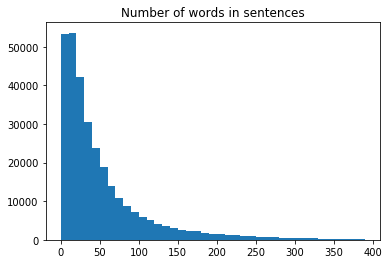

In [3]:
# check if there is null value
print(train.isnull().any())
print(test.isnull().any())

print('Processing text dataset')
# Regex to remove all Non-Alpha Numeric and space
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)

# regex to replace all numerics
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def text_to_wordlist(text, remove_stopwords=False, stem_words=False):   
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    
    # Remove Special Characters
    text=special_character_removal.sub('',text)
    
    # Replace Numbers
    text=replace_numbers.sub('n',text)
   
    # Return a list of words
    return(text)

sentences_train = train["comment_text"].fillna("NA").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
sentences_test = test["comment_text"].fillna("NA").values

comments = []
for text1 in sentences_train:
    comments.append(text_to_wordlist(text1))
    
test_comments=[]
for text2 in sentences_test:
    test_comments.append(text_to_wordlist(text2))

tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS)
# fit_on_text(texts): use texts(list) to generate token dictionary
tokenizer.fit_on_texts(comments + test_comments)

# texts_to_sequences(text): turn text into sequence number according the dictionary generated above
sequences = tokenizer.texts_to_sequences(comments) 
test_sequences = tokenizer.texts_to_sequences(test_comments) 

# a dictionary {word1: number1, word2: number2, ...}, including all the words from train and test data
word_index = tokenizer.word_index

# if the number of words in a sentence is below maxlen, fill the rest with 0(from left)
# if the number of words is beyond maxlen, reduce from the left until remaining maxlen
X_train = sequence.pad_sequences(sequences, maxlen=maxlen)
X_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)

# visualize data, we can see most sentences contain less than 150 words    
totalNumWords = [len(one_comment) for one_comment in sequences+test_sequences] 
plt.hist(totalNumWords,bins = np.arange(0,400,10))
plt.title("Number of words in sentences")
plt.show()

# Prepare embeddings

In [4]:
print('Preparing embedding matrix')
# convert X and y to torch TensorDataset format
test_loader = torch.utils.data.DataLoader(torch.from_numpy(X_test).long(), batch_size=1024)
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words+1, embed_size)) # well

# collect words and words' vectors from pretrain-glove file
# embeddings_index = {word1:vector1, word2:vector2, ...}
embeddings_index = {}
with open(emb_file) as f: 
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# i:postion, word: word, embedding_vector: word's vector
# use word_index and embeddings_index to generate embedding_matrix
# word's index is correspond to row number, and the row's values is word's vector  
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding_index will be all-zeros.
        embedding_matrix[i] = embedding_vector 

print("embedding matrix's shape: ", embedding_matrix.shape)

Preparing embedding matrix


NameError: name 'line' is not defined

# Define model, train and evaluation
We use a LSTM model, with mainly 7 sections: Embedding -> LSTM -> Maxpooling -> Dropout -> Fully connection -> Dropout -> Fully connection.
Besides, we use k-fold cross validation in our case. **Attention, for k-fold cross validation, error will occur if number of data is too small**

In [ ]:
from sklearn.model_selection import KFold
hidden_dim=50
pool_size = 50# 100
lin_dim = int(embed_size*maxlen/pool_size)

class Net(nn.Module):
    def __init__(self,max_features,embed_size,hidden_dim,pool_size,lin_dim):
        super(Net, self).__init__()
        p = .25 # drop rate
        self.embeddings = nn.Embedding(num_embeddings=max_features, embedding_dim=embed_size)
        self.embeddings.weight.data = torch.Tensor(embedding_matrix)
        # data structure (batch, time_step, input), if batch is in the first position,
        # then batch_first=True, otherwise false
        # input_siez=embed_size: number of input, hidden_size=50: number of neurons each layer,
        # num_layers=4: number of layer
        self.lstm = nn.LSTM(embed_size, hidden_dim, 2, batch_first=True, bidirectional=True)
        self.hidden = (
            Variable(torch.zeros(2, batch_size, 50)),
            Variable(torch.zeros(2, batch_size, 50))) # hidden state

        self.max_pool = nn.MaxPool1d(pool_size) # max pooling
        self.dropout = nn.Dropout(p=p) # apply drop out
        self.lin_1 = nn.Linear(lin_dim, 50) # fully connected layer
        self.relu = nn.ReLU() # activatoin function
        self.dropout_2 = nn.Dropout(p=p) # apply drop out
        self.lin_2 = nn.Linear(50, 6) # fully connected layer, six class
        self.bn = nn.BatchNorm2d(50)
        self.sig = nn.Sigmoid() # final result: probability

    def forward(self, x):
        x = self.embeddings(x) # (batch_size,embedded_size)->(batch_size,sentence_length,embedded_size)
        # every time it will return a hidden state, we use it
        # together with following data to generate new output
        # x, self.hidden = self.lstm(x, self.hidden)
        x, self.hidden = self.lstm(x) # (batch_size,sentence_length,embedded_size)
        # after pool: (batch_size, maxlen, embed_size/pool_size)
        x = self.max_pool(x) # need to select only the last output to pool?
        # x.view: unscroll data,x.size(0) not change, the rest turns into one dimmension
        x = x.view(x.size(0), -1) # (batch_size, maxlen * embed_size/pool_size)
        x = self.dropout(x) # apply drop out
        x = self.lin_1(x) # fully connected layer
        x = self.bn(x) # batch normalization
        x = self.relu(x) # apply activation function 
        x = self.dropout_2(x) # apply drop out
        x = self.lin_2(x) # fully connected layer
        return self.sig(x)

def mean_fun(onelist):
    count = 0
    for i in onelist:
        count += i
    return float(count/len(onelist))

def train(n_splits):
    learnin1g_rate = 1e-4
    # intialize the optimizer, use optimizer to accelorate learnnig process
    # there are different optimizers: SGD, Adagrad, Adadelta, Adam, Adamax, Nadam
    optimizer = optim.Adam(model.parameters(), lr=learnin1g_rate)
    # start model training
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    score_list = []
    for i, (inTr, inTe) in enumerate(kf.split(X_train, y)):
        xtr = X_train[inTr]
        xte = X_train[inTe]
        ytr = y[inTr]
        yte = y[inTe]
        train_set = torch.utils.data.TensorDataset(torch.from_numpy(xtr).long(), torch.from_numpy(ytr).float())
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
        valid_set = torch.utils.data.TensorDataset(torch.from_numpy(xte).long(), torch.from_numpy(yte).float())
        valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)

        model.train() 
        # batch_size:number of example to train every time, it will go through all the examples
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            y_pred = model(data)
            loss = F.binary_cross_entropy(y_pred, target) # binary cross entropy loss
            model.zero_grad() # orginal, clear gradients for this training step
            # optimizer.zero_grad() # myself, clear gradients for this training step
            loss.backward()
            #loss.backward(retain_graph=True)# myself
            optimizer.step() # apply gradients
        
        model.eval()
        preds = []
        for batch_idx, (data, _) in enumerate(valid_loader):
            data = Variable(data, volatile=True)
            output = model(data)
            pred = output.data
            preds.append(pred.numpy())

        y_test = np.concatenate(preds, axis=0)
        score = roc_auc_score(yte, y_test)
        score_list.append(score)
        print("epoch:", i+1, "|", "loss:", loss.data[0],"|", "score:", score)
    score_max = max(score_list)        
    score_mean = mean_fun(score_list)
    print("-----------------------------------------------------------------")
    print("Best score is:", score_max, ",", "Average score is:", score_mean)


# create Net for model
model = Net(max_features,embed_size,hidden_dim,pool_size,lin_dim)
print(model)
# start train()
time_start=time.time();
train(n_splits)
model.eval()# set training to false
time_end=time.time();
print("train complete")
print("total train time: ", (time_end-time_start)/3600, "h")

# Prediction

In [ ]:
# Predict the test data and save the result
preds = []
for data in test_loader:
    data = Variable(data, volatile=True)
    output = model(data)
    pred = output.data
    preds.append(pred.numpy())
y_test = np.concatenate(preds, axis=0)
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission[list_classes] = y_test
sample_submission.to_csv("submission_lstm.csv", index=False)

In [ ]:
files.download("submission_lstm.csv") # download the result from Google Colab

In [0]:
pred_test = pd.read_csv("submission_lstm.csv")
pred_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.977194,0.246823,0.874671,0.036069,0.756161,0.151352
1,0000247867823ef7,0.002163,0.000036,0.000333,0.000090,0.000308,0.000165
2,00013b17ad220c46,0.046709,0.000592,0.005277,0.001469,0.006918,0.002441
3,00017563c3f7919a,0.001579,0.000028,0.000197,0.000059,0.000236,0.000106
4,00017695ad8997eb,0.005452,0.000098,0.000817,0.000241,0.000833,0.000416


In [0]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
